In [435]:
import matplotlib.pyplot as plt
from tqdm import tqdm


In [470]:
%%writefile CT.py
import numpy as np
from functools import reduce
import scipy.sparse as sp
class CT_classical:
    def __init__(self,L,history=False,seed=None,x0=None):
        '''
        
        if classical is False: save using an array of 2^L
        '''
        self.L=L
        self.history=history
        self.rng=np.random.default_rng(seed)
        self.x0=self.rng.random() if x0 is None else x0
        self.op_history=[]  # control: true, Bernoulli: false
        self.binary=self._initialize_binary([1/6,1/3])

        self.vec=self._initialize_vector()
        self.vec_history=[self.vec]
    def _initialize_vector(self):
        '''save using an array of L'''
        vec=dec2bin(self.x0,self.L)
        return vec
    def _initialize_binary(self,x_list):
        return {x:dec2bin(x, self.L) for x in x_list}

    def Bernoulli_map(self,vec):
        vec=np.roll(vec,-1)
        vec[-2:]=self.rng.permutation(vec[-2:])        
        return vec
    
    def control_map(self,vec):
        vec[-1]=0
        vec=np.roll(vec,1)
        if vec[1]==0:
            # attract to 1/3
            vec=add_binary(vec,self.binary[1/6])
        else:
            # attract to 2/3
            vec=add_binary(vec,self.binary[1/3])
        return vec

    def random_control(self,p):
        '''
        p: the control probability
        '''
        p0=self.rng.random()
        vec=self.vec_history[-1].copy()
        if p0<p:
            vec=self.control_map(vec)
        else:
            vec=self.Bernoulli_map(vec)
        if self.history:
            self.vec_history.append(vec)
            self.op_history.append((p0<p))
        else:
            self.vec_history=[vec]
            self.op_history=[(p0<p)]

    def order_parameter(self):
        vec=self.vec_history[-1].copy()
        vec_Z=2*vec-1
        vec_Z_shift=np.roll(vec_Z,1)
        return -vec_Z@vec_Z_shift/self.L

class CT_quantum:
    def __init__(self,L,history=False,seed=None,x0=None):
        '''save using an array of 2^L'''
        self.L=L
        self.history=history
        self.rng=np.random.default_rng(seed)
        self.x0=self.rng.random() if x0 is None else x0
        self.op_history=[]  # control: true, Bernoulli: false
        self.vec=self._initialize_vector()
        self.vec_history=[self.vec]
        self.T={'L':T(self.L,left=True),'R':T(self.L,left=False)}
    
    def _initialize_vector(self):
        '''save using an array of 2^L'''
        vec_int=int(''.join(map(str,dec2bin(self.x0,self.L))),2)
        vec=np.zeros((2**self.L))
        vec[vec_int]=1
        return vec

    def Bernoulli_map(self,vec):
        vec=self.T['L']@vec
        vec=T(vec)
        vec=S(m,vec)
        return vec
    
    def control_map(self,vec):
        vec[-1]=0
        vec=np.roll(vec,1)
        if vec[1]==0:
            # attract to 1/3
            vec=add_binary(vec,self.binary[1/6])
        else:
            # attract to 2/3
            vec=add_binary(vec,self.binary[1/3])
        return vec

def dec2bin(x,L):
    '''
    convert a float number x in [0,1) to the binary form with maximal length of L, where the leading 0 is truncated
    Example, 1/3 is 010101...
    '''
    assert 0<=x<1, f'{x} is not in [0,1)'
    bits=[]
    for _ in range(L):
        x*=2
        bits.append(int(x))
        x-=int(x)
    return np.array(bits,dtype=int)

def add_binary(vec1,vec2):
    ''' adder for two `vec1` and `vec2`
    both are np.array
    return vec1
    '''
    assert vec1.shape[0]==vec2.shape[0], f'len of {vec1.shape[0]} is not same as len of {vec2.shape[0]}'
    vec_bin1=int(''.join(map(str,vec1)),2)
    vec_bin2=int(''.join(map(str,vec2)),2)
    vec_bin1=vec_bin1+vec_bin2
    vec1_sum=bin(vec_bin1)[2:]
    vec1_sum=vec1_sum.rjust(vec1.shape[0],'0')
    
    vec1_sum=list(map(int,list(vec1_sum)))
    if len(vec1_sum)>(vec1.shape[0]):
        return np.array(vec1_sum[1:]) #drop carry
    else:
        return np.array(vec1_sum)

def T(L,left=True):
    '''
    circular right shift the computational basis `vec` : 
    a_{L-1} a_{L-2}.. a_{1} a_{0} -> right shift -> a_{0} a_{L-1} a_{L-2}.. a_{1} 
    a_{L-1} a_{L-2}.. a_{1} a_{0} -> left shift -> a_{L-2}.. a_{1} a_{0} a_{L-1}
    '''
    SWAP=sp.csr_array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]],dtype=int)
    I2=sp.eye(2,dtype=int)
    op_list=[I2]*(L-1)
    kron_list=lambda x: reduce(sp.kron,x)
    rs=sp.eye(2**L,dtype=int)
    idx_list=np.arange(L-1)[::-1] if left else np.arange(L-1)
    for i in idx_list:
        op_list[i]=SWAP
        rs=rs@kron_list(op_list)
        op_list[i]=I2
    return rs

Overwriting CT.py


In [466]:
def     

In [467]:
[np.where(T(3).toarray()@np.eye(2**3)[x])[0] for x in range(2**3)]

[array([0]),
 array([2]),
 array([4]),
 array([6]),
 array([1]),
 array([3]),
 array([5]),
 array([7])]

In [468]:
[np.where(T(3,left=False).toarray()@np.eye(2**3)[x])[0] for x in range(2**3)]

[array([0]),
 array([4]),
 array([1]),
 array([5]),
 array([2]),
 array([6]),
 array([3]),
 array([7])]

In [430]:
ct=CT_quantum(L=6,x0=1/2,seed=0,history=True)

In [431]:
ct.vec

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [433]:
np.where(ct.vec==1)

(array([32]),)

In [434]:
ct.vec.shape

(64,)

In [34]:
np.roll(np.arange(4),-1)

array([1, 2, 3, 0])

In [35]:
np.random.permutation(np.arange(4))

array([2, 1, 0, 3])

In [183]:
add_binary(np.array([1,1,1,0]), np.array([0,0,1,1]))

[0, 0, 0, 1]

In [ ]:
def bin2dec(vec):
    '''
    convert vec to decimal
    vec: np.array of L
    '''
    

# Classical 

In [471]:
def run_classical(inputs):
    L,p,idx=inputs
    ct=CT_classical(L=L,x0=None,seed=idx,history=True)
    for _ in range(ct.L**2):
        ct.random_control(p=p)
    return ct.order_parameter()
    

In [359]:
def run_classical_thermalization(inputs):
    L,p,idx=inputs
    ct=CT_classical(L=L,x0=None,seed=idx,history=True)
    O_list=[]
    for _ in range(ct.L**2):
        ct.random_control(p=p)
        O_list.append(ct.order_parameter())
    return np.array(O_list)

In [472]:
from ipyparallel import Client
client = Client()

In [473]:
dview = client[:]

In [474]:
dview.execute('import numpy as np').wait()
dview.execute('from CT import *').wait()

True

In [484]:
L_list=np.array([40,60,80])
p_list=np.linspace(0,1,11)
ensemble=100
inputs=[(L,p,idx) for L in L_list for p in p_list for idx in range(ensemble)]

In [485]:
results = dview.map_async(run_classical, inputs)


In [486]:
results.progress

0

In [487]:
O_map=list(results)

In [481]:
O_map=np.array(O_map).reshape((L_list.shape[0],p_list.shape[0],ensemble))

In [482]:
O_map.shape

(3, 11, 50)

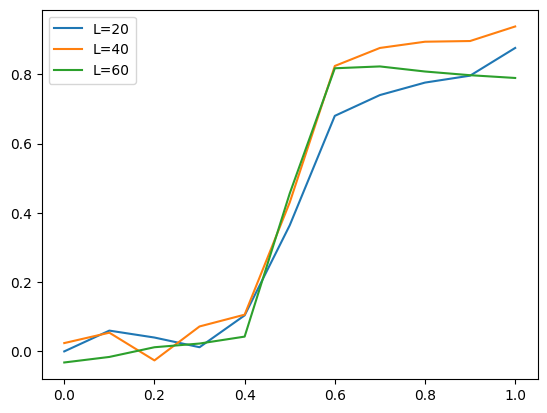

In [483]:
fig,ax=plt.subplots()
for i in range(O_map.shape[0]):
    ax.plot(p_list,O_map[i].mean(axis=-1),label=f'L={L_list[i]}')
ax.legend()
# plt.plot(p_list,O_map.mean(axis=-1).T)

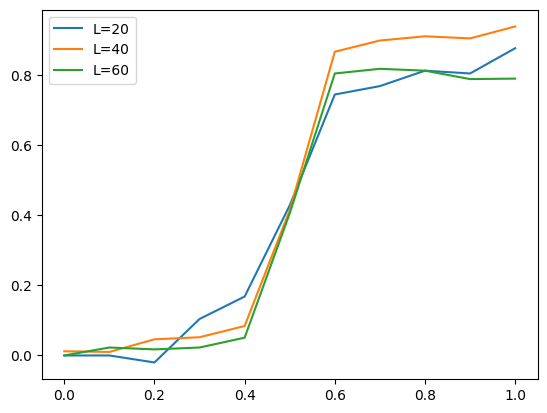

In [ ]:
fig,ax=plt.subplots()
for i in range(O_map.shape[0]):
    ax.plot(p_list,O_map[i].mean(axis=-1),label=f'L={L_list[i]}')
ax.legend()
# plt.plot(p_list,O_map.mean(axis=-1).T)

In [413]:
# L_list=np.array([20,40,60])
# p_list=np.linspace(0,1,11)
ensemble=50
inputs=[(40,.95,idx) for idx in range(ensemble)]

In [414]:
results_thermalization = dview.map_async(run_classical_thermalization, inputs)

In [415]:
results_thermalization.progress

0

In [416]:
O_map_therm=list(results_thermalization)

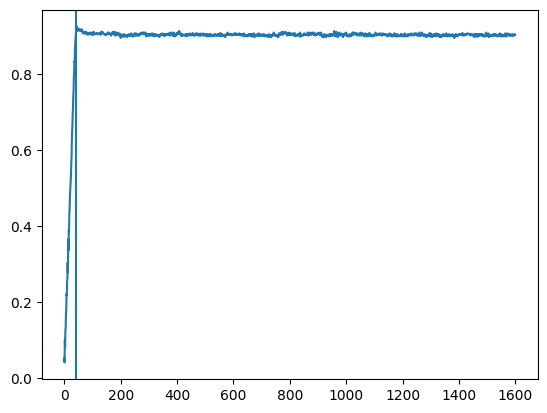

In [418]:
plt.plot(np.array(O_map_therm).mean(axis=0))
plt.axvline(x=40)

In [420]:
np.array(O_map_therm)

array([[ 0.2, -0.1,  0.2, ...,  0.9,  0.9,  0.9],
       [-0.1,  0.1, -0.2, ...,  0.9,  0.9,  0.9],
       [ 0.1,  0. ,  0. , ...,  0.9,  0.9,  0.9],
       ...,
       [ 0.1,  0.1,  0.2, ...,  0.9,  0.9,  0.9],
       [ 0.3, -0.2,  0.4, ...,  0.9,  0.9,  0.9],
       [ 0. ,  0. ,  0.1, ...,  0.9,  0.9,  0.9]])

In [382]:
O_map_therm=np.array(O_map_therm).reshape((ensemble,))

ValueError: cannot reshape array of size 80000 into shape (50,)

In [292]:
run_classical((20,0.1,1))

0.0

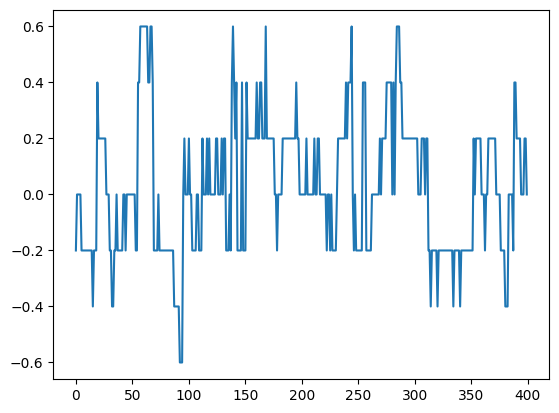

In [361]:
plt.plot(run_classical_thermalization((20,0.1,1)))

In [251]:
def 
p_list=np.linspace(0,1,11)
ensemble=20
O_list=np.zeros((p_list.shape[0],ensemble))
for p_idx,p in tqdm(enumerate(p_list)):
    for idx in tqdm(range(ensemble)):
        ct=CT(L=20,classical=True,x0=1/6,seed=idx,history=True)
        for _ in range(ct.L**2):
            ct.random_control(p=p)
        O_list[p_idx,idx]=(ct.order_parameter())

0it [00:00, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 24.71it/s]
11it [00:07,  1.40it/s]


In [253]:
O_list.shape

(11, 20)

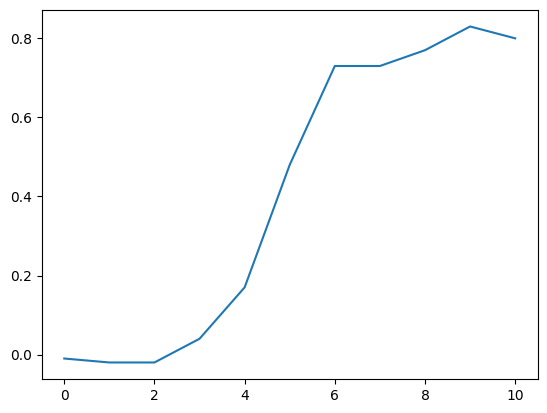

In [254]:
plt.plot(O_list.mean(axis=-1))

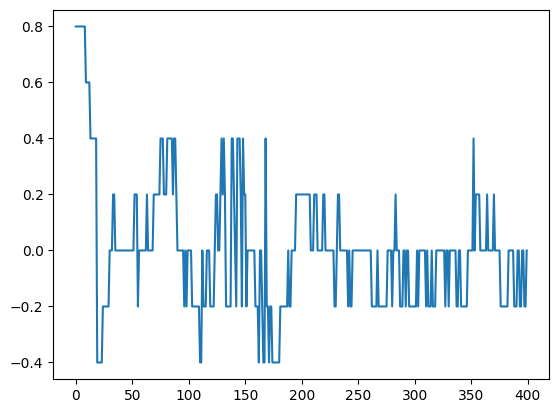

In [245]:
plt.plot(O_list)

In [233]:
ct.vec_history

[array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0]),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1]),
 array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0]),
 array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1]),
 array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0]),
 array([1, 0, 1, 0, 0, 1, 1, 1, 1, 0]),
 array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0]),
 array([1, 0, 1, 0, 1, 0, 0, 1, 1, 1]),
 array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1]),
 array([1, 0, 1, 0, 1, 0, 0, 0, 0, 1]),
 array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1]),
 array([0, 1, 0, 1, 0, 0, 1, 0, 1, 1]),
 array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1]),
 array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0]),
 array([1, 0, 1, 0, 1, 0, 1, 0, 0, 0]),
 array([1, 0, 1, 0, 1, 0, 1, 0, 0, 1]),


In [197]:
ct.op_history

[True, True]

In [59]:
ct.Bernoulli_map_classical(ct.vec)

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 0])

In [31]:
ct.vec

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [18]:
dec2bin(1/2, 10)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [9]:
float.hex(1/3)

'0x1.5555555555555p-2'

2